# IDS Bayesian Interferometry

In [1]:
from pymc3 import *
import numpy as np

In [2]:
def show_fft_image(img_fft):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
        
    img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    plt.show()

## Creating artificial data

In [3]:
size = 3
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 256
IMAGE_SIZE_Y = 256
SIGMA = 40

I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
Cx = np.clip(Cx,0,255)
Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
Cy = np.clip(Cy,0,255)

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print 'min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI])

min I: 43.0 at (82,101)
max I: 183.0 at (185,121)



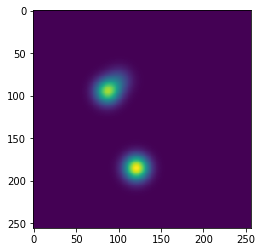

In [4]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy)
plt.imshow(Im_sinthc)
plt.show()

img = Im_sinthc #rename variable

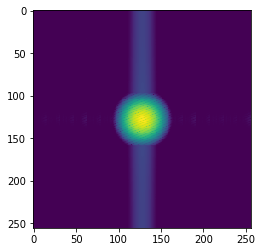

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

show_fft_image(np.log(img_fftabs+1e-12))

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

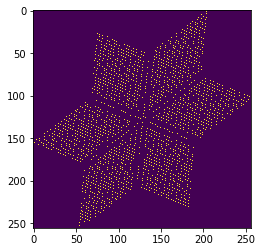

In [6]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'VLA'
sigma = B_max/6

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

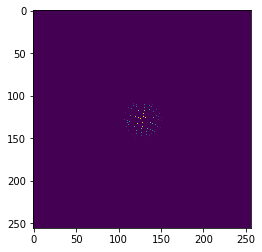

In [7]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+0.001)
show_fft_image(measurements_abs)


## RBF Model
### Priors

In [ ]:
numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = Model()

init_alpha = 128*np.ones(numberOfBasis)
init_Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cx = np.clip(Cx,0,255)
init_Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cy = np.clip(Cy,0,255)

with rbf_model:
    alpha_model = Normal('alpha', mu=init_alpha, sd=10, shape = numberOfBasis)
    Cx_model = Normal('Cx', mu=init_Cx, sd=10, shape = numberOfBasis)
    Cy_model = Normal('Cy', mu=init_Cy, sd=10, shape = numberOfBasis)
    l_model = HalfNormal('l', sd=1)
    sigma_model = HalfNormal('sigma', sd=1, shape = (2,2))
        
    V_model = np.zeros((numberOfSamplings,2), dtype=object) #Implementation zeros as object, not float
    
    for k in range(numberOfSamplings):
        u = U[k,0]
        v = U[k,1]
        for i in range(numberOfBasis):
            V_model[k,0] = V_model[k,0] + alpha_model[i]*phiRe(u,v, l_model, Cx_model[i], Cy_model[i])
            V_model[k,1] = V_model[k,1] + alpha_model[i]*phiIm(u,v, l_model, Cx_model[i], Cy_model[i])

    V_obs = Normal('V_obs', mu=V_model, sd=sigma_model, observed=V)